In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import astropy.constants as cons
import scipy.stats as scistat
import astropy.units as u
import astropy.cosmology as cosmo

### Load the initial power spectrum from the CLASS

In [2]:
Pk_CLASS = np.genfromtxt("../CLASS_Power_spectrum/CDM_0_434349__Baryon_0_02203/z99_9975_pk.dat")
k_class = Pk_CLASS[:,0]
Pk_class = Pk_CLASS[:,1]

## Defining interpolation function for the given power spectrum
f = interpolate.interp1d(k_class,Pk_class)


In [3]:
## The 1 dimensional length of the simulation box is defined below,
length = 64     ## in Mpc/h

### N is number of grid points
N = 64

## Average Density of the universe at the red shift of given initial power spectrum ,
## Here power spectrum is given at z = 100
## The density is taken as density/h^3 !!!
average_density_100 = cosmo.Planck15.critical_density(z=100).to(u.kg/(0.7*u.Mpc)**3).value


## As we have N^3 particles , we need to assign mass of the particle such that in the given volume 
## the average density of the box would be same as average density of the universe. scale with a^3
mass_particle = average_density_100* (length*(1/(1+100))/N)**3 

## Smallest distance between two grid points,
dx = length/N
# print("Smallest scale spacial scale in the simulation should be =",dx,"Mpc/h")

## Defining the 3 Dimensional array 
bin_edges = np.arange(N+1)*dx

x_array = (np.roll(bin_edges,-1)+bin_edges)[:-1]/2
y_array = (np.roll(bin_edges,-1)+bin_edges)[:-1]/2
z_array = (np.roll(bin_edges,-1)+bin_edges)[:-1]/2

## Frequency for the given grid points
k_array = np.fft.fftfreq(N,d=dx)

## Generating random gaussian scaler field in fourier space
random_gaussian = np.random.normal(0,1,(N,N,N))

# FFT_random_gaussian = np.random.normal(0,1,(N,N,N))
FFT_random_gaussian = np.fft.fftn(random_gaussian)/(N**(3))
# IFFT_random_gaussian = np.fft.ifftn(FFT_random_gaussian)

print("Number of grid points = ",N,"\n")

## Box size
length = (N)*dx
print("Length of the box will be = ",length,"Mpc/h")

print("Smallest scale spacial scale in the simulation should be =",dx,"Mpc/h")

Number of grid points =  64 

Length of the box will be =  64.0 Mpc/h
Smallest scale spacial scale in the simulation should be = 1.0 Mpc/h


### Generating field which can have shape of power spectrum with random fluctuations

In [4]:
Gk = np.zeros((N,N,N),dtype=complex)

for m in range(N):
    for n in range(N):
        for o in range(N):
        
            if (m != 0 or n != 0 or o != 0):
            
                k_norm = np.sqrt(k_array[m]**2+k_array[n]**2+k_array[o]**2)
                
                ## Here 'f' gives the interpolation value from the power spectrum
                Gk[m][n][o] = FFT_random_gaussian[m][n][o] * np.sqrt(f(k_norm))
     
    print(m,end="\r")

In [23]:
## k_power_spectrum is the frequency array which has all positive frequencies from zeros to the k_power_spectrum_highest
k_power_spectrum = np.linspace(0,np.sqrt(3*(np.max(np.abs(k_array))**2)),30)

power_spectrum_initial = np.zeros(len(k_power_spectrum))
count = np.zeros(len(k_power_spectrum))

for m in range(len(k_array)):
    for n in range(len(k_array)):
        for o in range(len(k_array)):
        
            k_norm = np.sqrt(k_array[m]**2+k_array[n]**2+k_array[o]**2)

            power_spectrum_initial[np.abs(k_norm-k_power_spectrum).argmin()] += np.abs(Gk[m][n][o])**2
            count[np.abs(k_norm-k_power_spectrum).argmin()] += 1
    print(m,end="\r")
    
power_spectrum_initial = power_spectrum_initial*(N**3)/(count)

(0.05, 3)

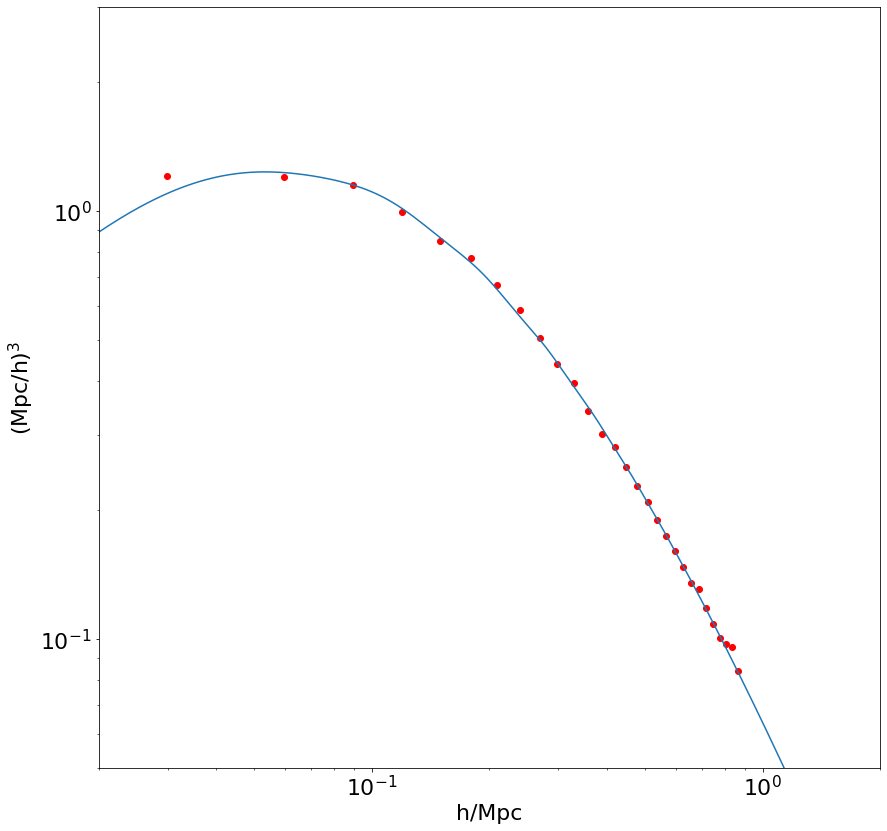

In [43]:
plt.figure(figsize=(14,14))
plt.rcParams.update({'font.size': 22})
plt.xlabel("h/Mpc")
plt.ylabel("(Mpc/h)$^{3}$")
plt.loglog(k_class,Pk_class,'-')
plt.scatter(k_power_spectrum,power_spectrum_initial,c='r')
plt.xlim(0.02,2)
plt.ylim(0.05,3)

### From our defination

$$  < \delta^{2}  > = P_{k}   \left( \frac{2 \pi}{L} \right)^{3}  $$ 

In [26]:
Gk_f = Gk * (((2*np.pi)/length)**(3/2))

#### To find scaler field zeta

$$  \hat{\zeta} =  -\frac{\hat{\delta}}{k^{2}}   $$ 

Displacement 

$$  \delta x = \frac{\partial \zeta_{i}}{\partial x_{i}}  $$

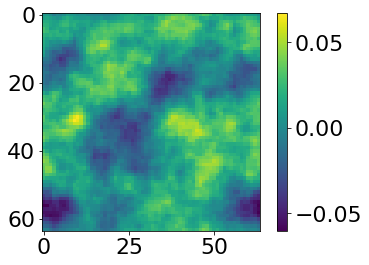

In [27]:
J = N
L = N
O = N

zeta = np.zeros((N,N,N),dtype=complex)
 
for m in range(N):
    for n in range(N):
        for o in range(N):

            if ((m != 0) or (n != 0) or (o != 0)):

                zeta[m][n][o] = (-Gk_f[m][n][o]*(dx**2))/(2*(np.cos(2*np.pi*m/J)+np.cos(2*np.pi*n/L)+np.cos(2*np.pi*o/O)-3)) 

    print(m,end='\r')

zeta[0][0][0] = 0 + 0j
    
scaler_field = np.fft.ifftn(zeta)/((N**(-3)))

plt.imshow(scaler_field[int(N/2)].real)
plt.colorbar()

In [28]:
displacement_field_x = (np.roll(scaler_field,shift=-1,axis=0)-np.roll(scaler_field,shift=1,axis=0)).real/(2*dx)
displacement_field_y = (np.roll(scaler_field,shift=-1,axis=1)-np.roll(scaler_field,shift=1,axis=1)).real/(2*dx)
displacement_field_z = (np.roll(scaler_field,shift=-1,axis=2)-np.roll(scaler_field,shift=1,axis=2)).real/(2*dx)

Distance between two grid points =  1.0 Mpc/h


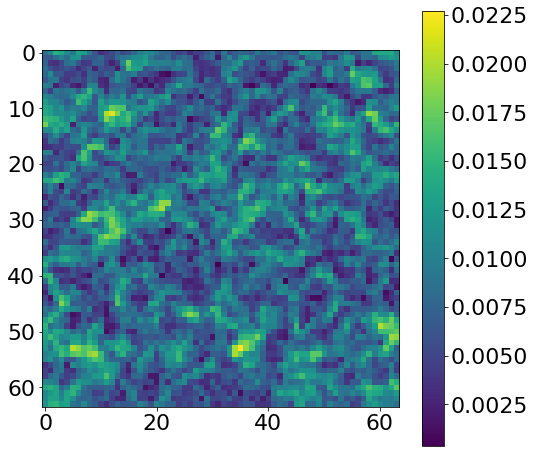

In [29]:
total_displacement = np.sqrt(displacement_field_x**2 + displacement_field_y**2 + displacement_field_z**2)

plt.figure(figsize=(8,8))
plt.imshow(total_displacement[int(N/2)])
# plt.imshow((displacement_field_x[int(N/2)]))
plt.colorbar()
# plt.colorbar.set_ylabel("displacement (Mpc/h)")
print("Distance between two grid points = ",dx,"Mpc/h")

In [30]:
### we want all the particles on the exact grid points... 
## Here the x_pos, y_pos, z_pos discribed the position as [x][y][z]
y_pos,x_pos,z_pos = np.meshgrid(x_array,x_array,x_array)

In [31]:
x_displaced = x_pos + displacement_field_x
y_displaced = y_pos + displacement_field_y
z_displaced = z_pos + displacement_field_z

In [42]:
# writing displaced position of particles in text file
# with open("IC_position__CDM_0_434349__Baryons_0_02203__grid_"+str(N)+"_length_"+str(int(length))+".txt",'w') as f:
#     x_displaced_flatten = x_displaced.flatten()
#     y_displaced_flatten = y_displaced.flatten()
#     z_displaced_flatten = z_displaced.flatten()
    
#     for i in range(len(x_displaced_flatten)):
#         y = np.str(x_displaced_flatten[i]) + " " + np.str(y_displaced_flatten[i]) + " " + np.str(z_displaced_flatten[i]) 
#         f.write(y)
#         f.write('\n')

## To generate power spectrum from the given distribution of density in 3 Dimension

### For CIC projection

In [33]:
## Here I create an array which have one fake array after all 3 dimentional bounadry to pass the value 
## across the box
x_array_CIC = np.hstack((x_array[0]-dx,x_array,x_array[-1]+dx))
y_array_CIC = np.hstack((y_array[0]-dx,y_array,y_array[-1]+dx))
z_array_CIC = np.hstack((z_array[0]-dx,z_array,z_array[-1]+dx))

## density grid including a fake grid on corners
rho_grid = np.zeros((len(x_array_CIC),len(y_array_CIC),len(z_array_CIC))) 

## ALERT
## The convention of variables are different then in N body.
## Here rho[x][y][z] and in N body rho[z][y][x] 
## As we compare power spectrum this difference will not effect the power spectrum.

for i in range(N):
    for j in range(N):
        for k in range(N):
            
            
            ## The below shift will push the particles from right side corner to left side
            ##  and left side outof the box to right side. Periodic Boundary condition
            if (x_displaced[i][j][k] > x_array_CIC[-1]):
                x_displaced[i][j][k] = x_displaced[i][j][k] - length
            if (y_displaced[i][j][k] > y_array_CIC[-1]):
                y_displaced[i][j][k] = y_displaced[i][j][k] - length
            if (z_displaced[i][j][k] > z_array_CIC[-1]):
                z_displaced[i][j][k] = z_displaced[i][j][k] - length
            
            if (x_displaced[i][j][k] < x_array_CIC[0]):
                x_displaced[i][j][k] = x_displaced[i][j][k] + length
            if (y_displaced[i][j][k] < y_array_CIC[0]):
                y_displaced[i][j][k] = y_displaced[i][j][k] + length
            if (z_displaced[i][j][k] < z_array_CIC[0]):
                z_displaced[i][j][k] = z_displaced[i][j][k] + length
                  
            a0 = np.where(np.abs(x_displaced[i][j][k]-x_array_CIC)<dx)[0][0]
            a1 = np.where(np.abs(y_displaced[i][j][k]-y_array_CIC)<dx)[0][0]
            a2 = np.where(np.abs(z_displaced[i][j][k]-z_array_CIC)<dx)[0][0]
            
            a0_dist = np.round(np.abs(x_displaced[i][j][k]-x_array_CIC[a0]),6)
            a1_dist = np.round(np.abs(y_displaced[i][j][k]-y_array_CIC[a1]),6)
            a2_dist = np.round(np.abs(z_displaced[i][j][k]-z_array_CIC[a2]),6)

            try:

                b2 = np.where(np.abs(z_displaced[i][j][k]-z_array_CIC)<dx)[0][0]
                b2_dist = a2_dist

                b1 = np.where(np.abs(y_displaced[i][j][k]-y_array_CIC)<dx)[0][0]
                b1_dist = a1_dist

                b0 = np.where(np.abs(x_displaced[i][j][k]-x_array_CIC)<dx)[0][1]

                b0_dist = dx - a0_dist

            except IndexError:

                b0_dist = dx
                b0 = a0 + 1

            try: 

                c2 = np.where(np.abs(z_displaced[i][j][k]-z_array_CIC)<dx)[0][0]
                c2_dist = a2_dist

                c0 = np.where(np.abs(x_displaced[i][j][k]-x_array_CIC)<dx)[0][0]
                c0_dist = a0_dist

                c1 = np.where(np.abs(y_displaced[i][j][k]-y_array_CIC)<dx)[0][1]
                c1_dist = dx - a1_dist

            except IndexError:

                c1_dist = dx
                c1 = a1 + 1 

            try:    
                d2 = np.where(np.abs(z_displaced[i][j][k]-z_array_CIC)<dx)[0][0]
                d2_dist = a2_dist

                d0,d1 = np.where(np.abs(x_displaced[i][j][k]-x_array_CIC)<dx)[0][1],np.where(np.abs(y_displaced[i][j][k]-y_array_CIC)<dx)[0][1]

            except IndexError:

                d0 = a0 + 1
                d1 = a1 + 1

            d0_dist = dx - a0_dist
            d1_dist = dx - a1_dist

            try:

                e0 = np.where(np.abs(x_displaced[i][j][k]-x_array_CIC)<dx)[0][0]
                e0_dist = a0_dist
                e1 = np.where(np.abs(y_displaced[i][j][k]-y_array_CIC)<dx)[0][0]
                e1_dist = a1_dist
                e2 = np.where(np.abs(z_displaced[i][j][k]-z_array_CIC)<dx)[0][1]
                e2_dist = dx - a2_dist

            except IndexError:

                e2 = a2 + 1 
                e2_dist = dx

            try:

                f1 = np.where(np.abs(y_displaced[i][j][k]-y_array_CIC)<dx)[0][0]
                f1_dist = a1_dist

                f0 = np.where(np.abs(x_displaced[i][j][k]-x_array_CIC)<dx)[0][1]
                f0_dist = dx - a0_dist

            except IndexError:

                f0 = a0 + 1 
                f0_dist = dx

            try:

                f2 = np.where(np.abs(z_displaced[i][j][k]-z_array_CIC)<dx)[0][1]
                f2_dist = dx - a2_dist

            except IndexError:

                f2 = a2 + 1 
                f2_dist = dx


            try:

                g0 = np.where(np.abs(x_displaced[i][j][k]-x_array_CIC)<dx)[0][0]
                g0_dist = a0_dist

                g1 = np.where(np.abs(y_displaced[i][j][k]-y_array_CIC)<dx)[0][1]
                g1_dist = dx - a1_dist

            except IndexError:

                g1 = a1 + 1 
                g1_dist = dx

            try:

                g2 = np.where(np.abs(z_displaced[i][j][k]-z_array_CIC)<dx)[0][1]
                g2_dist = dx - a2_dist

            except IndexError:

                g2 = a2 + 1 
                g2_dist = dx


            try:

                h2 = np.where(np.abs(z_displaced[i][j][k]-z_array_CIC)<dx)[0][1]
                h2_dist = dx - a2_dist

            except IndexError:

                h2 = a2 + 1 
                h2_dist = dx

            try:

                h1 = np.where(np.abs(y_displaced[i][j][k]-y_array_CIC)<dx)[0][1]
                h1_dist = dx - a1_dist

            except IndexError:

                h1 = a1 + 1 
                h1_dist = dx

            try:

                h0 = np.where(np.abs(x_displaced[i][j][k]-x_array_CIC)<dx)[0][1]
                h0_dist = dx - a0_dist

            except IndexError:

                h0 = a0 + 1 
                h0_dist = dx

            rho_grid[a2][a1][a0] += np.round(h0_dist*h1_dist*h2_dist/dx**3,6)*mass_particle
            rho_grid[b2][b1][b0] += np.round(g0_dist*g1_dist*g2_dist/dx**3,6)*mass_particle
            rho_grid[c2][c1][c0] += np.round(f0_dist*f1_dist*f2_dist/dx**3,6)*mass_particle
            rho_grid[d2][d1][d0] += np.round(e0_dist*e1_dist*e2_dist/dx**3,6)*mass_particle
#             print(i,j,k,a2,e2,e1,e0)
            rho_grid[e2][e1][e0] += np.round(d0_dist*d1_dist*d2_dist/dx**3,6)*mass_particle
            rho_grid[f2][f1][f0] += np.round(c0_dist*c1_dist*c2_dist/dx**3,6)*mass_particle
            rho_grid[g2][g1][g0] += np.round(b0_dist*b1_dist*b2_dist/dx**3,6)*mass_particle
            rho_grid[h2][h1][h0] += np.round(a0_dist*a1_dist*a2_dist/dx**3,6)*mass_particle
            
    print(i,end="\r")
    
density_final = np.zeros_like(rho_grid)

density_final[:,:,1] = rho_grid[:,:,-1] + rho_grid[:,:,1] 
density_final[:,:,-2] = rho_grid[:,:,0] + rho_grid[:,:,-2]

density_final[:,1,:] = rho_grid[:,-1,:] + rho_grid[:,1,:] 
density_final[:,-2,:] = rho_grid[:,0,:] + rho_grid[:,-2,:]

density_final[1,:,:] = rho_grid[-1,:,:] + rho_grid[1,:,:] 
density_final[-2,:,:] = rho_grid[0,:,:] + rho_grid[-2,:,:]

density_final[2:-2,2:-2,2:-2] = rho_grid[2:-2,2:-2,2:-2]

density_grid = density_final[1:-1,1:-1,1:-1]/(dx**3)

(2.7569842635478262e+40, 2.840541210832672e+46)

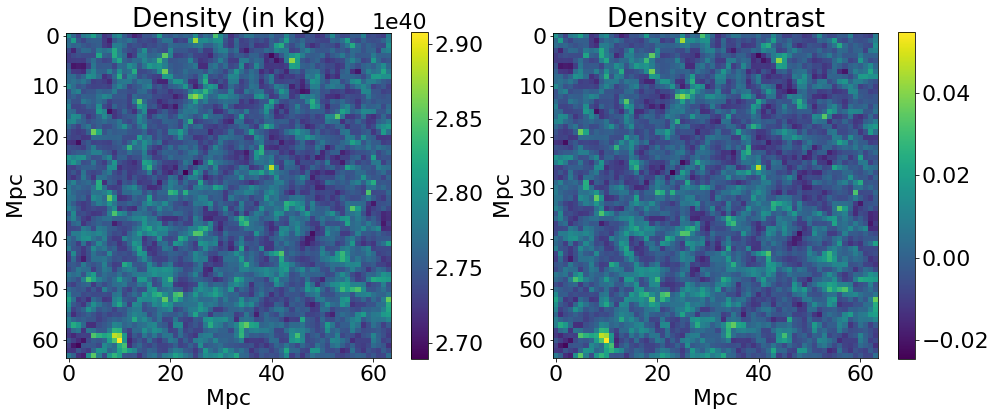

In [34]:
rho_average = (mass_particle*(N**3))/((length)**3)
delta_grid = (density_grid - rho_average)/rho_average

## Comparing both the results
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 6))

rho1 = ax1.imshow(density_grid[int(N/2)])
ax1.set_title("Density (in kg)")
ax1.set_xlabel(" Mpc ")
ax1.set_ylabel(" Mpc ")
fig.colorbar(rho1, ax=ax1)

rho2 = ax2.imshow(delta_grid[int(N/2)])
ax2.set_title("Density contrast")
ax2.set_xlabel(" Mpc ")
ax2.set_ylabel(" Mpc ")
fig.colorbar(rho2, ax=ax2)
# plt.savefig("density_and_delta_N32.png")
# rho_average
np.mean(density_grid),average_density_100

In [35]:
delta_check_FFT = np.fft.fftn(delta_grid)/(N**3)

power_spectrum = np.zeros(len(k_power_spectrum))
count = np.zeros(len(k_power_spectrum))

for m in range(len(k_array)):
    for n in range(len(k_array)):
        for o in range(len(k_array)):
        
            k_norm = np.sqrt(k_array[m]**2+k_array[n]**2+k_array[o]**2)

            power_spectrum[np.abs(k_norm-k_power_spectrum).argmin()] += np.abs(delta_check_FFT[m][n][o])**2
            count[np.abs(k_norm-k_power_spectrum).argmin()] += 1
    print(m,end="\r")
    
power_spectrum = power_spectrum*(N**3)*((length/(2*np.pi))**(3))/(count)

(0.05, 3)

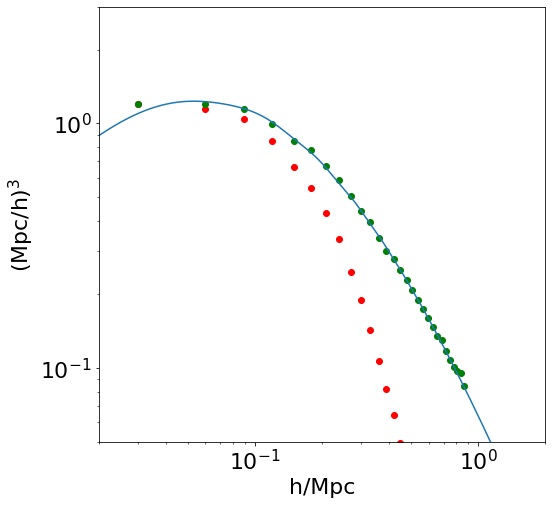

In [36]:
plt.figure(figsize=(8,8))
plt.rcParams.update({'font.size': 22})
plt.xlabel("h/Mpc")
plt.ylabel("(Mpc/h)$^{3}$")
plt.loglog(k_class,Pk_class,'-')
plt.scatter(k_power_spectrum,power_spectrum,c='r')
plt.scatter(k_power_spectrum,power_spectrum_initial,c='g')
plt.xlim(0.02,2)
plt.ylim(0.05,3)

## To generate Initial Velocity

First generate 3 dimensional $\delta$ from the given initial power spectrum

### Initial $\Phi$

$$ \Delta \Phi = 4 \pi G a^{2} \bar{\rho} \delta    $$ 

In [37]:
J = N
L = N
O = N

a = 0.01

Mpc_to_km = (u.Mpc).to(u.km)

phi_fft_grid = np.zeros((len(k_array),len(k_array),len(k_array)),dtype=complex)

for m in range(len(k_array)):
    for n in range(len(k_array)):
        for o in range(len(k_array)):

            if ((m != 0) or (n != 0) or (o != 0)):
#                 print(m,n,o,end='\r')
                phi_fft_grid[m][n][o] = (Gk_f[m][n][o]*(dx**2))/(2*(np.cos(2*np.pi*m/J)+np.cos(2*np.pi*n/L)+np.cos(2*np.pi*o/O)-3)) 

    print(m,end='\r')

phi_fft_grid[0][0][0] = 0 + 0j

phi_fft_grid = phi_fft_grid * (4*np.pi*cons.G.value* (((u.m).to(u.km))**3) *(a**2))*average_density_100/Mpc_to_km


# phi_fft_grid = phi_fft_grid * (cons.G.value*(((u.m).to(u.km))**3)*(a**2))*average_density_100/(((u.Mpc).to(u.km)))

## Calculating the initial phi on the mesh point from the FFT

phi_grid = np.zeros((len(k_array),len(k_array),len(k_array)),dtype=complex)
phi_grid = np.fft.ifftn(phi_fft_grid)*(N**(3))

### Intial velocity
$$   v_{\mathrm{i}} = -\frac{2}{3 \ H}  \frac{\partial{\Phi}}{\partial{x_{\mathrm{i}}}}   $$ 

In [38]:
### For matter only universe
# H = 100*np.sqrt((0.3/0.01)+(0.7*0.01))    ### In unit of  'h'
H = 100 * np.sqrt(1/(0.01))              ### In unit of  'h'

vx_initial = -(2/(3*H))*(np.real(np.roll(phi_grid,-1,axis=0)-np.roll(phi_grid,1,axis=0)))/(2*dx)
vy_initial = -(2/(3*H))*(np.real(np.roll(phi_grid,-1,axis=1)-np.roll(phi_grid,1,axis=1)))/(2*dx)
vz_initial = -(2/(3*H))*(np.real(np.roll(phi_grid,-1,axis=2)-np.roll(phi_grid,1,axis=2)))/(2*dx)

In [41]:
### Writing the intial velocity in the text file

# with open('IC_velocity__CDM_0_434349__Baryons_0_02203__grid_'+str(N)+'_length_'+str(int(length))+'.txt','w') as f:
#     vx_initial_flatten = vx_initial.flatten()
#     vy_initial_flatten = vy_initial.flatten()
#     vz_initial_flatten = vz_initial.flatten()
    
#     for i in range(len(vx_initial_flatten)):
#         y = np.str(vx_initial_flatten[i]) + " " + np.str(vy_initial_flatten[i]) + " " + np.str(vz_initial_flatten[i]) 
#         f.write(y)
#         f.write('\n')

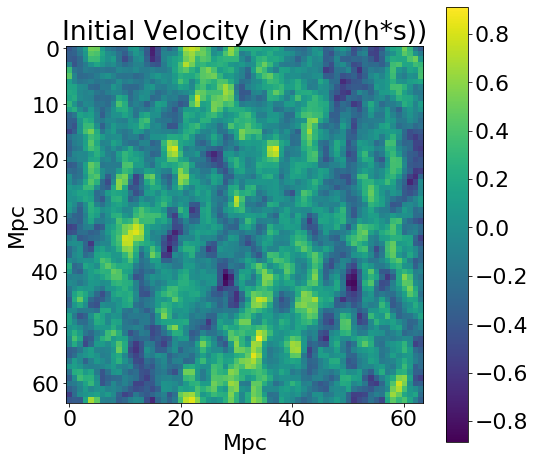

In [40]:
plt.figure(figsize=(8,8))
plt.rcParams.update({'font.size': 22})
plt.imshow(vz_initial[:,10,:])
plt.xlabel("Mpc")
plt.ylabel("Mpc")
plt.title("Initial Velocity (in Km/(h*s))")
plt.colorbar()
# plt.savefig("initial_velocity_N64.png")